In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [ ]:
!pip install keras_tuner
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.2 MB/s eta 0:00:00


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2011completefinaldatasets.csv')

data.shape

(720, 8)

# Exploratory Data Analysis

In [15]:
# Convert "Time" to datetime and set as index
data['Time'] = pd.to_datetime(data['Time'] + '-1', format='%Y-w%W-%w')

data.head(), data.tail()

(        Time  Rainfall  MaxTemperature  AverageTemperature  MinTemperature  \
 0 2011-01-03  9.938571       29.444400           25.888890       23.888900   
 1 2011-01-10  8.587143       30.000000           26.705556       24.444444   
 2 2011-01-17  5.338571       30.000000           26.616667       25.000000   
 3 2011-01-24  5.410000       30.555556           26.483333       20.555556   
 4 2011-01-31  2.914286       28.333333           25.283333       18.650000   
 
     Wind   Humidity  Cases  
 0  11.39  86.242857      5  
 1   7.32  88.028571      4  
 2   7.55  84.028571      2  
 3  10.67  80.971429      7  
 4  11.01  74.885714      2  ,
           Time  Rainfall  MaxTemperature  AverageTemperature  MinTemperature  \
 715 2024-09-30     1.016       33.333333           28.866667       25.555556   
 716 2024-10-07     9.652       32.777778           28.561111       25.000000   
 717 2024-10-14    25.400       33.333333           29.083333       25.000000   
 718 2024-10-21    

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time                720 non-null    datetime64[ns]
 1   Rainfall            720 non-null    float64       
 2   MaxTemperature      720 non-null    float64       
 3   AverageTemperature  720 non-null    float64       
 4   MinTemperature      720 non-null    float64       
 5   Wind                720 non-null    float64       
 6   Humidity            720 non-null    float64       
 7   Cases               720 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 45.1 KB


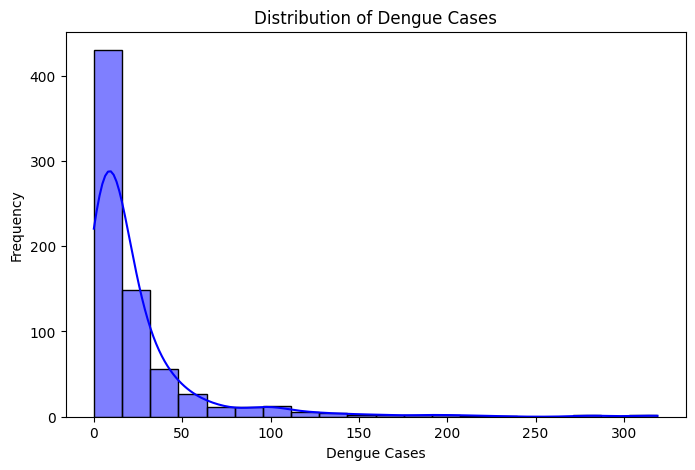

,Time,Rainfall,MaxTemperature,AverageTemperature,MinTemperature,Wind,Humidity,Cases
count,720,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2017-12-02 11:22:00,13.957499,32.191142,28.110319,25.038472,6.172417,81.609442,23.744444
min,2011-01-03 00:00:00,0.000000,-14.600000,24.494444,12.222222,1.910000,73.185714,0.000000
25%,2014-06-21 06:00:00,1.270000,31.666667,27.504167,25.000000,4.117500,79.885713,5.000000
50%,2017-12-07 12:00:00,4.318000,32.222222,28.161111,25.000000,5.725000,81.771429,12.000000
75%,2021-05-11 18:00:00,10.414000,32.777778,28.751389,25.555556,7.860000,83.503571,26.000000
max,2024-10-28 00:00:00,445.008000,58.333333,30.916667,32.222222,19.200000,89.571429,319.000000
std,NaN,35.448846,2.616379,0.999800,1.291659,2.446703,2.831674,37.144813


In [ ]:
# Summary statistics
summary_stats = data.describe()

# Distribution of dengue cases
plt.figure(figsize=(8, 5))
sns.histplot(data["Cases"], bins=20, kde=True, color="blue")
plt.xlabel("Dengue Cases")
plt.ylabel("Frequency")
plt.title("Distribution of Dengue Cases")
plt.show()

# Display summary statistics
summary_stats

In [ ]:
# # Categorizing dengue cases into intervals
# bins = [0, 5, 15, 30, 100, 320]  # Case intervals
# labels = ["0-5", "6-15", "16-30", "31-100", "101+"]  # Interval labels
# data["Cases_Interval"] = pd.cut(data["Cases"], bins=bins, labels=labels, right=False)

# # Count plot for different case intervals
# plt.figure(figsize=(8, 5))
# sns.countplot(x="Cases_Interval", data=data, palette="coolwarm", order=labels)
# plt.xlabel("Dengue Case Intervals")
# plt.ylabel("Frequency")
# plt.title("Frequency of Dengue Cases in Different Intervals")
# plt.show()

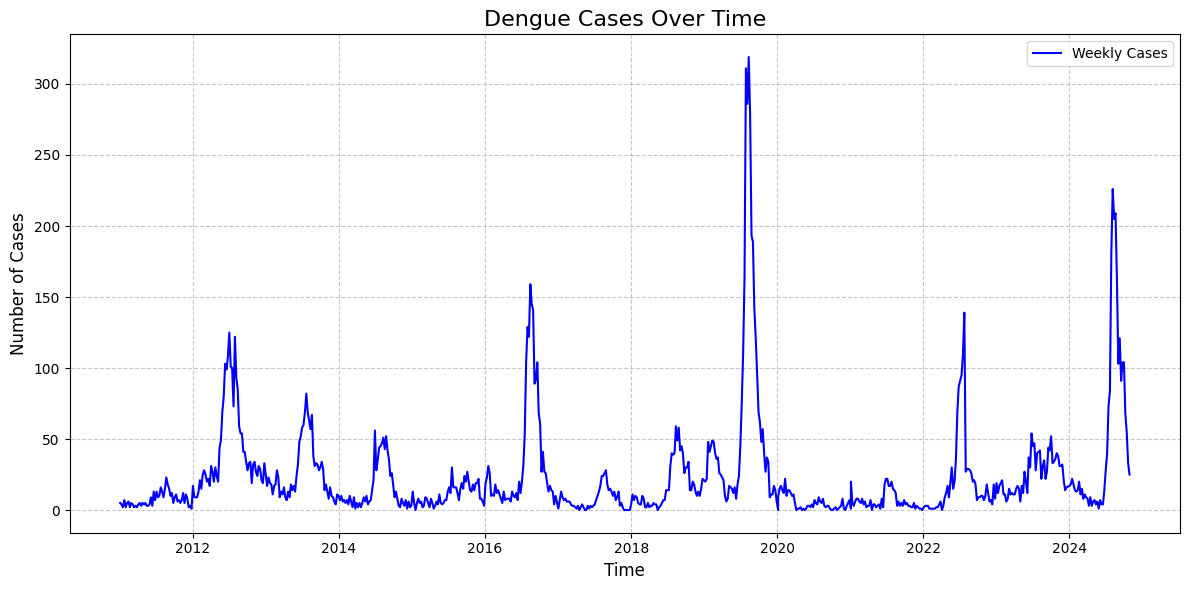

In [ ]:
# Analyze the cases over time to observe seasonality
plt.figure(figsize=(12, 6))
plt.plot(data['Time'][:len(data)], data['Cases'], color='blue', label='Weekly Cases')
plt.title('Dengue Cases Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Compute correlation between weather factors and cases
correlation_matrix = data.corr()
case_correlation = correlation_matrix['Cases'].sort_values(ascending=False)

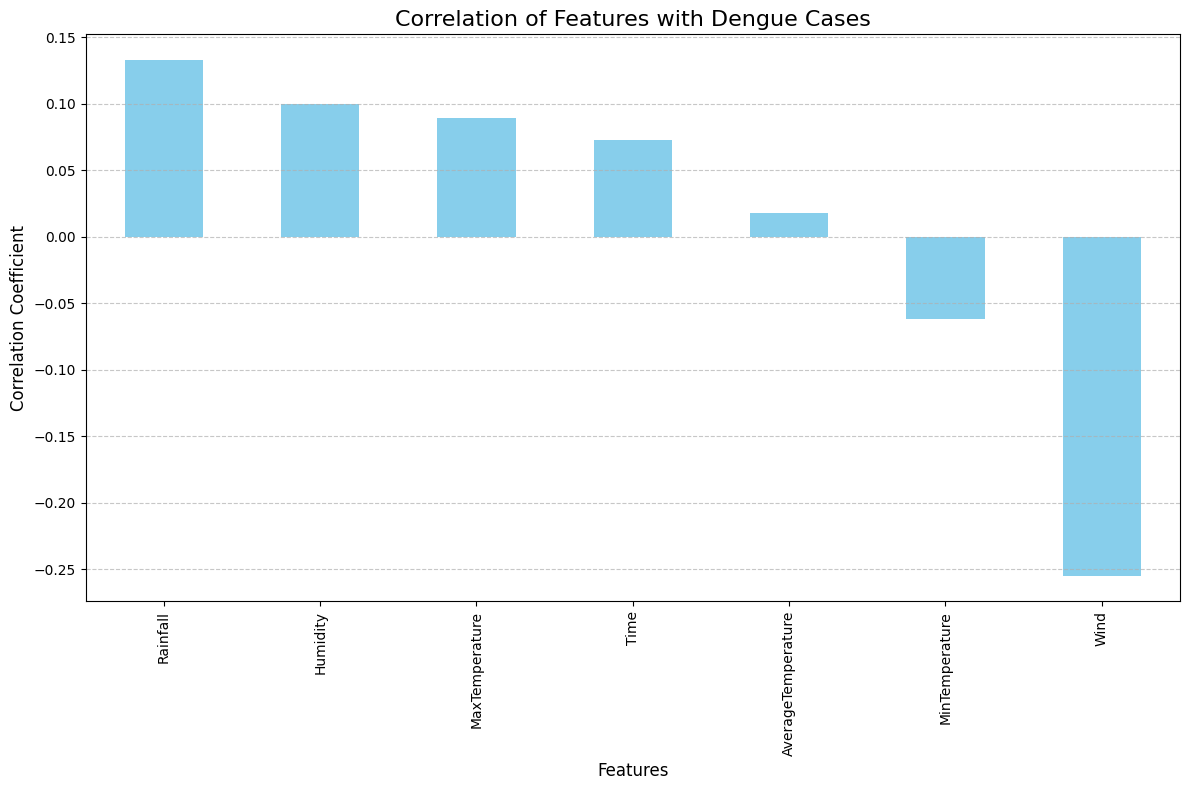

In [ ]:
# Plot correlation of all features with Cases
plt.figure(figsize=(12, 8))
case_correlation.drop('Cases').plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Dengue Cases', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# Identify top 3 correlated weather factors with cases
original_features = ['Rainfall', 'Humidity', 'MaxTemperature', 'AverageTemperature', 'MinTemperature', 'Wind', 'Cases']

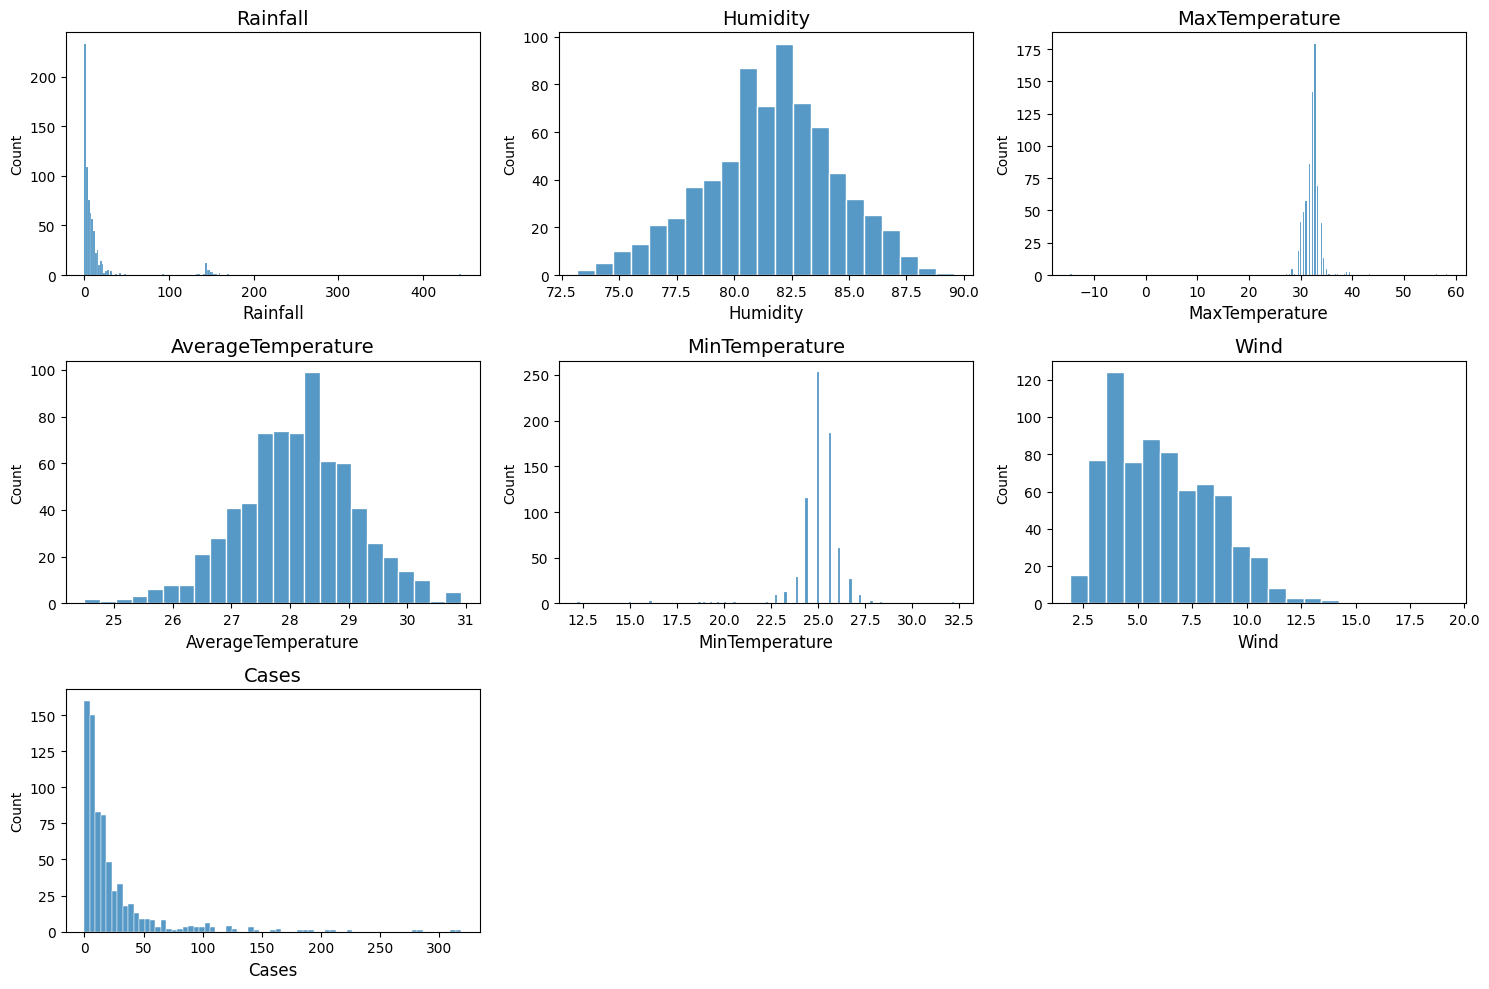

In [17]:
# Plot relationships between top factors and cases
plt.figure(figsize=(15, 10))
for i, factor in enumerate(original_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(x=data[factor], edgecolor='w')
    plt.title(f'{factor}', fontsize=14)
    plt.xlabel(factor, fontsize=12)
plt.tight_layout()
plt.show()

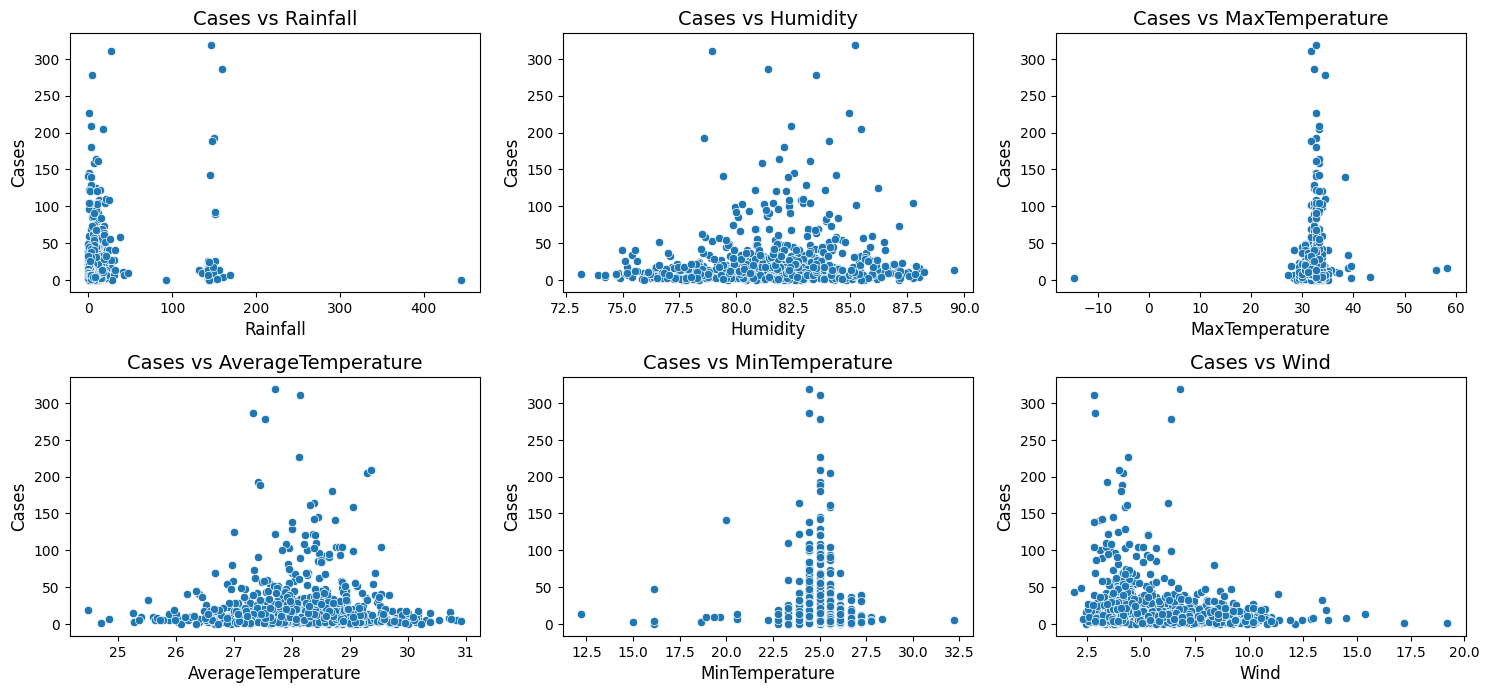

In [ ]:
# Plot relationships between top factors and cases
plt.figure(figsize=(15, 10))
for i, factor in enumerate(top_3_factors, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[factor], y=data['Cases'], edgecolor='w')
    plt.title(f'Cases vs {factor}', fontsize=14)
    plt.xlabel(factor, fontsize=12)
    plt.ylabel('Cases', fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
data['log_Rainfall'] = np.log(data['Rainfall'])
data['log_MaxTemperature'] = np.log(data['MaxTemperature'])
data['log_MinTemperature'] = np.log(data['MinTemperature'])
data['log_Wind'] = np.log(data['Wind'])
data['log_Cases'] = np.log(data['Cases'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# Identify top 3 correlated weather factors with cases
transformed_features = ['log_Rainfall', 'Humidity', 'log_MaxTemperature', 'AverageTemperature', 'log_MinTemperature', 'log_Wind']

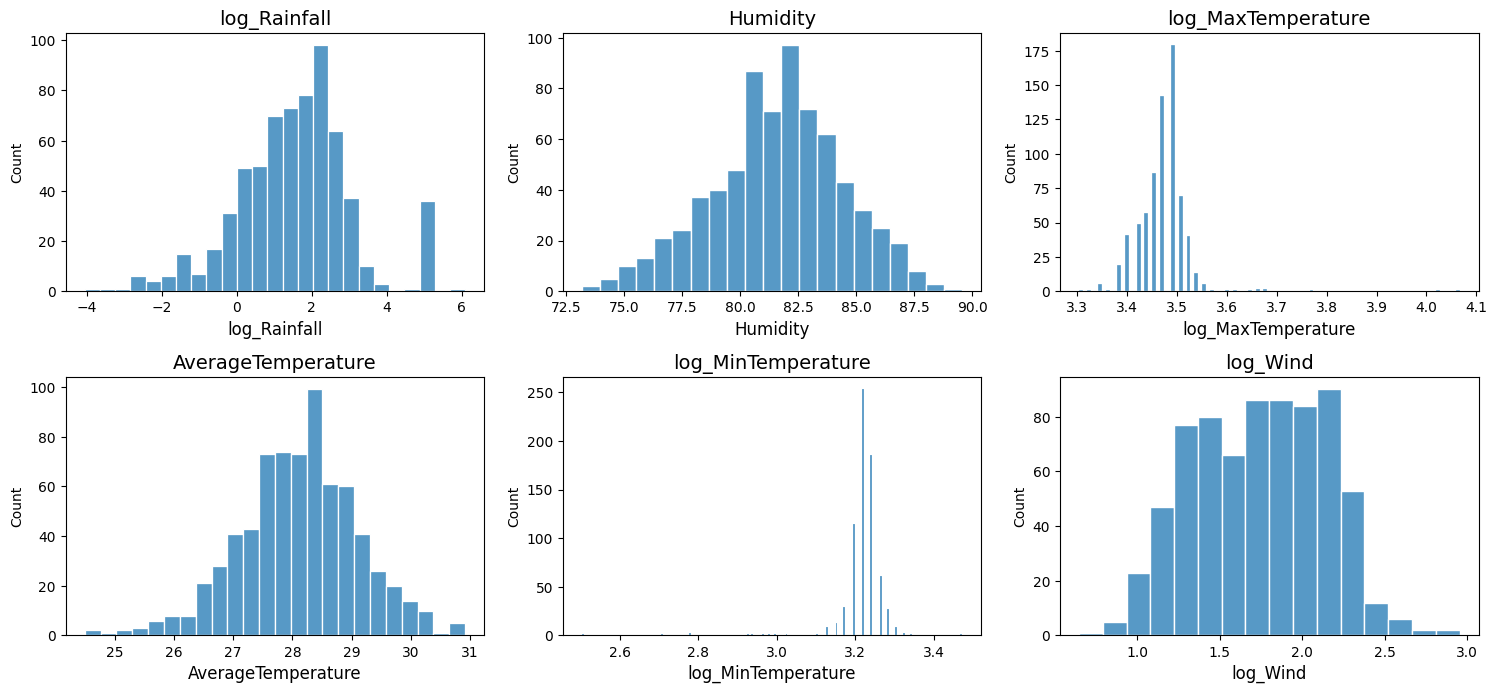

In [21]:
# Plot relationships between top factors and cases
plt.figure(figsize=(15, 10))
for i, factor in enumerate(transformed_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(x=data[factor], edgecolor='w')
    plt.title(f'{factor}', fontsize=14)
    plt.xlabel(factor, fontsize=12)
plt.tight_layout()
plt.show()

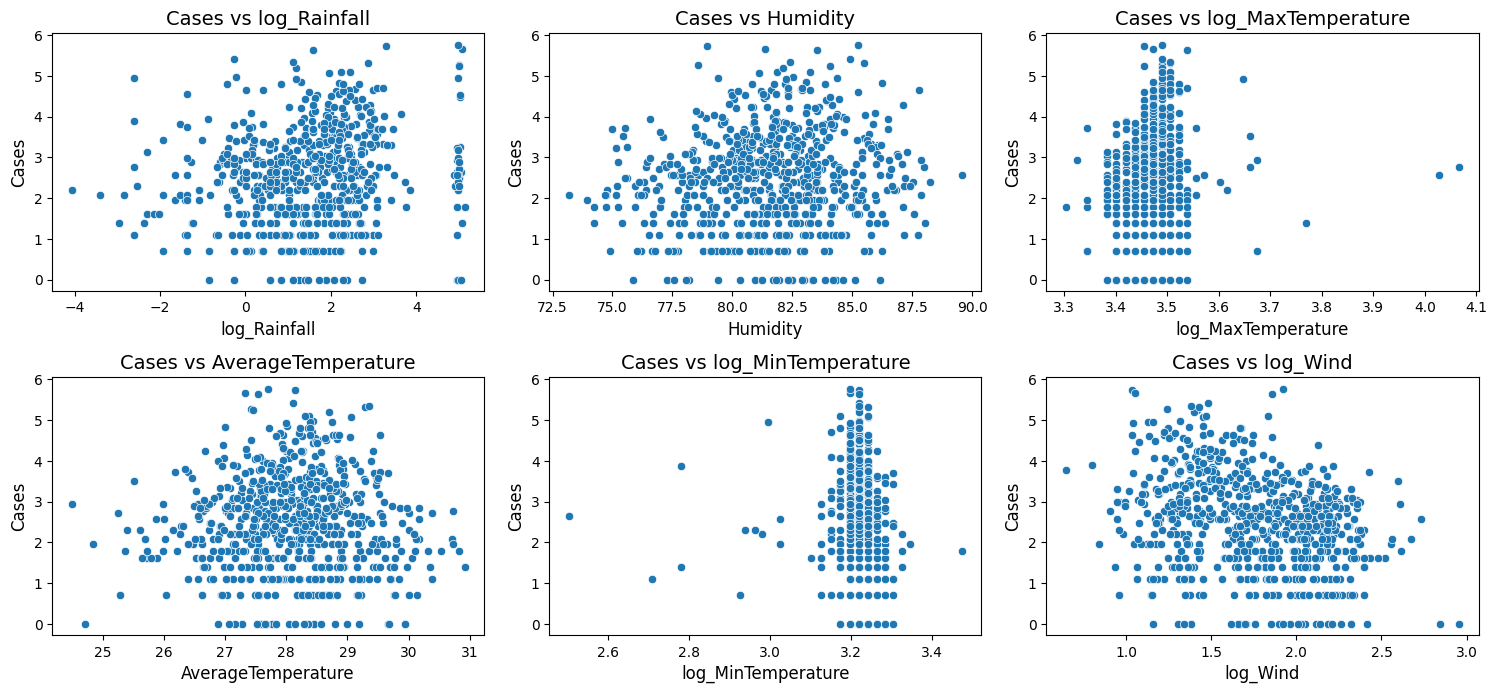

In [23]:
# Plot relationships between top factors and cases
plt.figure(figsize=(15, 10))
for i, factor in enumerate(transformed_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[factor], y=data['log_Cases'], edgecolor='w')
    plt.title(f'Cases vs {factor}', fontsize=14)
    plt.xlabel(factor, fontsize=12)
    plt.ylabel('Cases', fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
# Compute correlation between weather factors and cases
correlation_matrix = data.corr()
case_correlation = correlation_matrix['log_Cases'].sort_values(ascending=False)

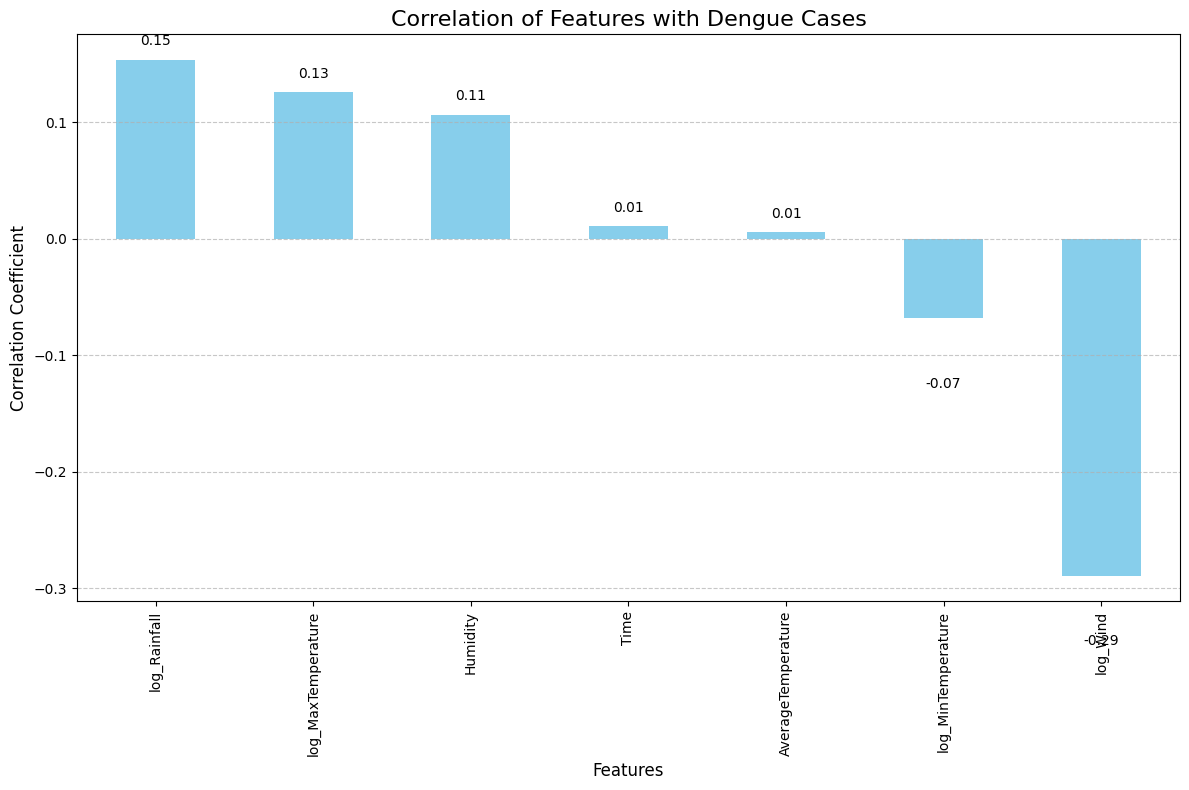

In [26]:
# Plot correlation of selected features with Cases
plt.figure(figsize=(12, 8))
filtered_correlation = case_correlation.drop(['Rainfall', 'MaxTemperature', 'MinTemperature', 'Wind', 'Cases', 'log_Cases'])
ax = filtered_correlation.plot(kind='bar', color='skyblue')

plt.title('Correlation of Features with Dengue Cases', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for i, value in enumerate(filtered_correlation):
    plt.text(i, value + 0.01 if value >= 0 else value - 0.05, f'{value:.2f}',
             ha='center', va='bottom' if value >= 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()


#Outbreak Computation

In [ ]:
# Get the last four datapoints (1 month)
last_four_rows = data.tail(4)

# Create a new DataFrame containing the last four rows
last_four_df = data.tail(4)

# Summary statistics for the entire dataset
month_summary_stats = last_four_df.describe()

# Display the summary statistics
print(month_summary_stats)

                      Time   Rainfall  MaxTemperature  AverageTemperature  \
count                    4   4.000000        4.000000            4.000000   
mean   2024-10-17 12:00:00  14.541500       32.500000           28.348611   
min    2024-10-07 00:00:00   2.540000       31.666667           27.455556   
25%    2024-10-12 06:00:00   7.874000       32.083333           28.084722   
50%    2024-10-17 12:00:00  15.113000       32.500000           28.427778   
75%    2024-10-22 18:00:00  21.780500       32.916667           28.691667   
max    2024-10-28 00:00:00  25.400000       33.333333           29.083333   
std                    NaN  10.364061        0.717219            0.679572   

       MinTemperature      Wind   Humidity      Cases  
count        4.000000  4.000000   4.000000   4.000000  
mean        24.861111  5.265000  84.128571  45.250000  
min         23.888889  4.260000  82.385714  25.000000  
25%         24.722222  4.597500  83.607143  31.000000  
50%         25.000000  4.8

#Training

In [ ]:
# Select features for normalization (excluding the target column)
features = data[['Rainfall', 'MaxTemperature','Humidity']]
target = data['Cases']

features.shape, target.shape

((720, 3), (720,))

In [ ]:
# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

normalized_features = scaler_features.fit_transform(features)
normalized_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Convert back to DataFrame for better manipulation
normalized_data = pd.DataFrame(normalized_features, columns=features.columns, index=data.index)
normalized_data['Cases'] = normalized_target

In [ ]:
normalized_data.head()

,Rainfall,MaxTemperature,Humidity,Cases
0,0.022333,0.603899,0.796861,0.015674
1,0.019297,0.611517,0.905841,0.012539
2,0.011997,0.611517,0.661726,0.006270
3,0.012157,0.619135,0.475153,0.021944
4,0.006549,0.588665,0.103749,0.006270


In [ ]:
# Function to create sequences for LSTM
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the number of LSTM units
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), activation='relu'))

    # Output layer
    model.add(Dense(1))

    # Tune the learning rate
    lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model


In [ ]:
# Initialize variables for results
window_sizes = [5, 10,20]
val_losses = []
histories = []
results = {}

In [ ]:
# Loop over different window sizes
for window_size in window_sizes:
    # Prepare the sequences using the current window size
    X, y = create_sequences(normalized_data.values, normalized_target, window_size)

    # Split into training and testing sets (80% training, 20% testing)
    split_index = int(len(X) * 0.80)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    # Create tuner instance
    tuner = BayesianOptimization(
        hypermodel=build_model,
        objective='val_loss',
        max_trials=10,                # Increased for better exploration
        executions_per_trial=3,       # More executions for stable results
        overwrite=True,               # Ensures reproducibility during re-runs
        directory='kt_dir',
        project_name='dengue_lstm_tuning',
        seed=42                       # Seed for reproducibility
    )

    # Perform the search for best hyperparameters
    tuner.search(X_train, y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=1)

    # Get the best hyperparameters and build model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters: Units = {best_hps.get('units')}, Learning rate = {best_hps.get('lr')}")
    model = tuner.hypermodel.build(best_hps)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=1,
                        validation_data=(X_test, y_test), verbose=1,
                        callbacks=[early_stopping])
    val_loss = model.evaluate(X_test, y_test, verbose=0)

    val_losses.append(val_loss)
    histories.append(history)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Rescale back to original dengue case values
    y_train_actual_scale = scaler_target.inverse_transform(y_train)
    y_train_predicted_scale = scaler_target.inverse_transform(model.predict(X_train))

    predicted_actual_scale = scaler_target.inverse_transform(y_pred)
    y_test_actual_scale = scaler_target.inverse_transform(y_test)

    #Compute MSE and RMSE for train data
    train_mse = mean_squared_error(y_train_actual_scale, y_train_predicted_scale)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_actual_scale, y_train_predicted_scale)
    train_r2 = r2_score(y_train_actual_scale, y_train_predicted_scale)

    # Compute MSE and RMSE for test data
    test_mse = mean_squared_error(y_test_actual_scale, predicted_actual_scale)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_actual_scale, predicted_actual_scale)
    test_r2 = r2_score(y_test_actual_scale, predicted_actual_scale)

    # Store results
    results[window_size] = {
        'best_hyperparameters': {
            'units': best_hps.get('units'),
            'learning_rate': best_hps.get('lr')
        },
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'train_predicted': y_train_predicted_scale.flatten(),
        'train_actual': y_train_actual_scale.flatten(),
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'predicted': predicted_actual_scale.flatten(),
        'actual': y_test_actual_scale.flatten(),
        'history': history
    }

Trial 10 Complete [00h 00m 28s]
val_loss: 0.00018662312747134516

Best val_loss So Far: 0.0001750170049490407
Total elapsed time: 00h 04m 38s
Best hyperparameters: Units = 80, Learning rate = 0.01
Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 10/1

In [ ]:
# Display MSE and RMSE for different window sizes TRAINING DATA
for window_size, result in results.items():
    print(f"Window Size {window_size} - TRAIN MSE: {result['train_mse']:.2f}, TRAIN RMSE: {result['train_rmse']:.2f}, TRAIN MAE: {result['train_mae']:.2f}, TRAIN R2: {result['train_r2']:.2f}")

Window Size 5 - TRAIN MSE: 103.94, TRAIN RMSE: 10.20, TRAIN MAE: 5.83, TRAIN R2: 0.92
Window Size 10 - TRAIN MSE: 154.23, TRAIN RMSE: 12.42, TRAIN MAE: 6.67, TRAIN R2: 0.88
Window Size 20 - TRAIN MSE: 132.71, TRAIN RMSE: 11.52, TRAIN MAE: 5.99, TRAIN R2: 0.90


In [ ]:
# Display best hyperparameters for different window sizes
for window_size, result in results.items():
    print(f"Window Size {window_size} - Best Hyperparameters: Units={result['best_hyperparameters']['units']}, Learning Rate={result['best_hyperparameters']['learning_rate']}")

Window Size 5 - Best Hyperparameters: Units=96, Learning Rate=0.01
Window Size 10 - Best Hyperparameters: Units=96, Learning Rate=0.01
Window Size 20 - Best Hyperparameters: Units=80, Learning Rate=0.01


# Evaluation Metrics

#Training Set

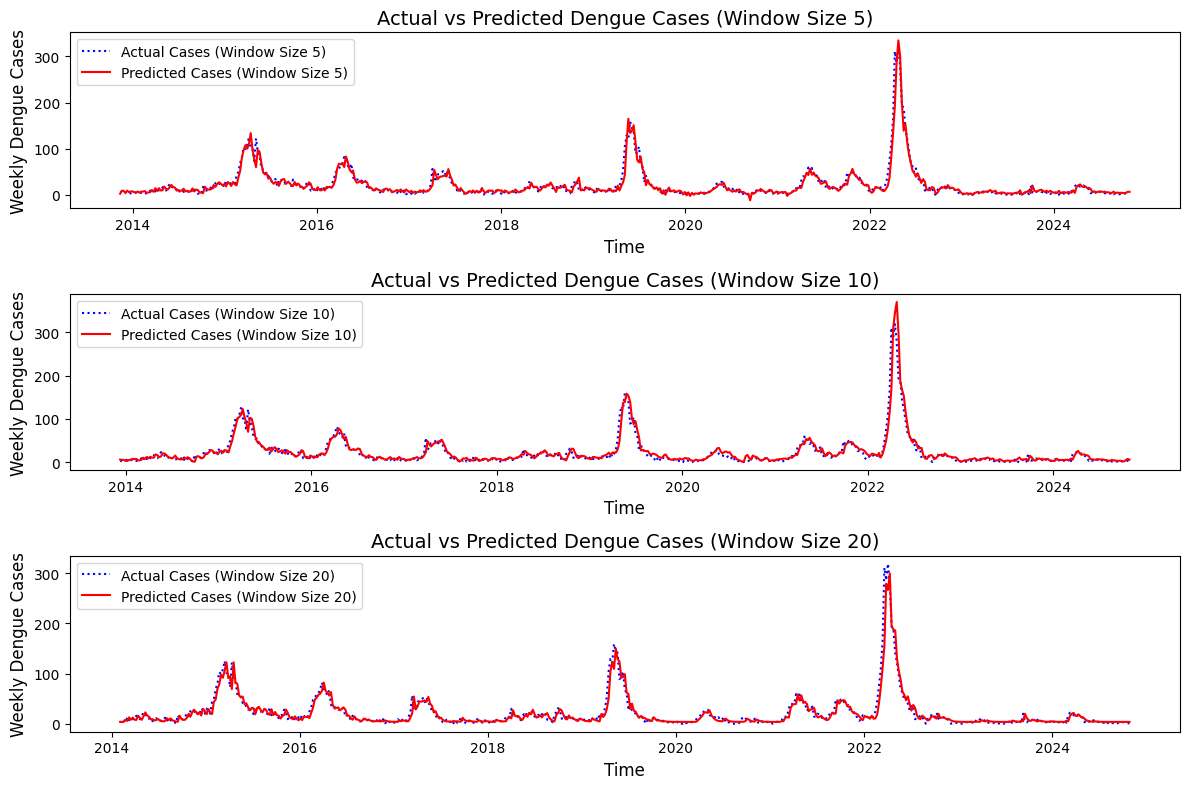

In [ ]:
# Plot the performance for different window sizes in separate plots
plt.figure(figsize=(12, 8))
for i, (window_size, result) in enumerate(results.items(), 1):
    plt.subplot(len(results), 1, i)  # Create a subplot for each window size
    plt.plot(
        data['Time'][len(data) - len(result['train_actual']):],
        result['train_actual'],
        label=f'Actual Cases (Window Size {window_size})',
        linestyle='dotted',
        color='blue'
    )
    plt.plot(
        data['Time'][len(data) - len(result['train_predicted']):],
        result['train_predicted'],
        label=f'Predicted Cases (Window Size {window_size})',
        color='red'
    )
    plt.title(f'Actual vs Predicted Dengue Cases (Window Size {window_size})', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Weekly Dengue Cases', fontsize=12)
    plt.legend()
    plt.tight_layout()

plt.show()

#Test Set

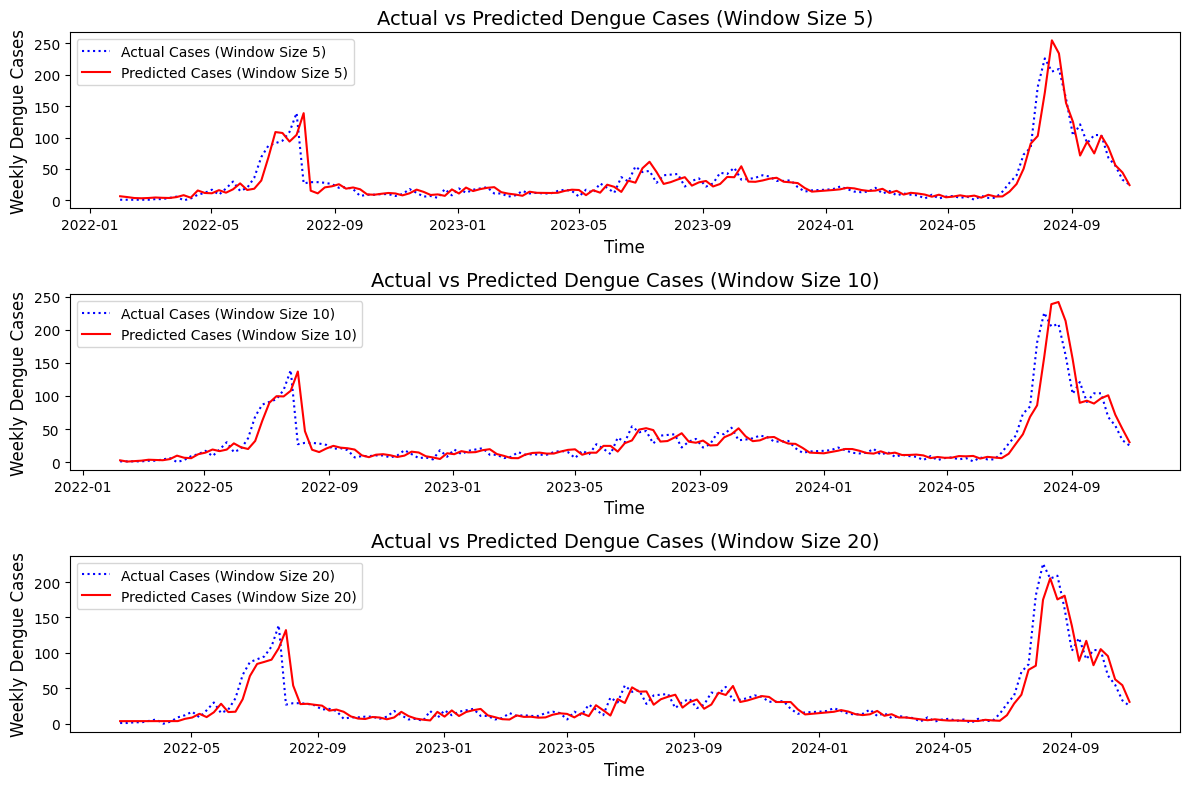

In [ ]:
# Plot the performance for different window sizes in separate plots
plt.figure(figsize=(12, 8))
for i, (window_size, result) in enumerate(results.items(), 1):
    plt.subplot(len(results), 1, i)  # Create a subplot for each window size
    plt.plot(
        data['Time'][len(data) - len(result['actual']):],
        result['actual'],
        label=f'Actual Cases (Window Size {window_size})',
        linestyle='dotted',
        color='blue'
    )
    plt.plot(
        data['Time'][len(data) - len(result['predicted']):],
        result['predicted'],
        label=f'Predicted Cases (Window Size {window_size})',
        color='red'
    )
    plt.title(f'Actual vs Predicted Dengue Cases (Window Size {window_size})', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Weekly Dengue Cases', fontsize=12)
    plt.legend()
    plt.tight_layout()

plt.show()


In [ ]:
# Display MSE and RMSE for different window sizes TEST DATA
for window_size, result in results.items():
    print(f"Window Size {window_size} - TEST MSE: {result['test_mse']:.2f}, TEST RMSE: {result['test_rmse']:.2f}, TEST MAE: {result['test_mae']:.2f}, TEST R2: {result['test_r2']:.2f}")

Window Size 5 - TEST MSE: 285.54, TEST RMSE: 16.90, TEST MAE: 9.45, TEST R2: 0.83
Window Size 10 - TEST MSE: 334.63, TEST RMSE: 18.29, TEST MAE: 9.85, TEST R2: 0.80
Window Size 20 - TEST MSE: 294.85, TEST RMSE: 17.17, TEST MAE: 9.35, TEST R2: 0.83


### Choose the best window size

In [ ]:
best_index = np.argmin(val_losses)
best_window_size = window_sizes[best_index]
print(f"Best window size: {best_window_size}")

Best window size: 5
